# Nonlinear Regression

This notebook will develop some relatively advanced approaches for solving more challenging optimization problems; specifically, we consider problems where there is no analytical solution for model predictions. In these cases, we must use numerical methods to evaluate the objective function. It is not apparent yet, but this means that our solutions will involve two numerical methods--one to solve the objective function, and one to optimize the objective function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import pandas as pd

## Nonlinear Least Squares Recap:

We should have a good feel for least squares analysis at this point. So far, we have used both linear least squares and nonlinear least squares to find determine rate laws and estimate kinetic parameters. Today, we will use nonlinear least squares exclusively. The basic problem in kinetic analysis usually involves having aa single model that describes an observable quantity in our reactor. For example, below we have the solution for $C_A(t)$ in the case of a single, first order, irreversible reaction in a constant volume batch reactor:

$$C_A = C_{A0}e^{-kt}$$

We would like to apply this model to our measured data. In this case, our measurements would be the concentration of $A$, $C_A$ as a function of $t$. When we perform an experiment, we might generate 10, 20, 50, or more $(C_A, t)$ pairs, and we would like our model to predict all of them. This is an inverse, data anlysis problem, so when we formulate the system, we will have many equations (10, 20, 50, or more -- one equation per measurement), but we will only have a few unknowns. In this case, our single unknown parameter is the rate constant $k$. In theory, this model equation should be satisfied for all data points, but in practice, this is never true. The system is overdetermined (e.g., 50 independent equations, 1 unknown), and experimental errors mean that there is no unique solution.  Instead, we have to find the *best* values of the parameters of interest. In our context, the *best* value is the one that minimizes the total sum of square errors between our measurement and our model's prediction.

$$SSE = \sum_i(y_i - \hat{y}_i)^2$$

No matter what problem you are trying to solve, the method behind nonlinear least squares is always the same:

1. Propose a model that includes your variable parameters (e.g., a rate constant or reaction order)
2. Use that model to calculate the value of your measurable quantity at each experimental condition (e.g., a concentration at a specific time)
3. Calculate the square error between your measurement and the value predicted by your model
4. Sum the square errors for each data point.
5. Use an iterative solver to vary the parameters of interest until the sum of square errors is at a minimum.

## Example Problem 01

We want to determine the rate constant for the following reaction:

$$A \longrightarrow B$$

For this experiment, we use a constant volume batch reactor, and we know a few things about the reaction.  First, the rate of reaction is first order in species $A$. Second, the rate is independent of the concentration of $B$. Based on the above, we write the following rate law:

$$r = kC_A$$

Finally, the concentration of $A$ at the start of the experiment was quantified very precisely.  We know that it is equal to $C_{A0} = 15 \mathrm{M}$. Otherwise, the only information that we have is that we measured the concentration of the reactant, $C_A$, as a function of reaction time. The data are compiled in separate CSV files, `t1.csv` and `C1.csv`. We will import this data and then convert it into numpy arrays. Times are in minutes, and concentrations are in mol/L.

In [2]:
#################################################################################################
# Define the initial concentrations of A, B, C, and D -- these are fixed, global defs are fine  #
#################################################################################################

CA01    = 15.0 #mol/L

#################################################################################################
# Load experimental measurements for first problem into a data frame                            #
#################################################################################################

DATA1df = pd.read_csv("N45_DATA1.csv")

#################################################################################################
# Convert data frame to numpy array --> easier for elementwise math                             #
#################################################################################################

DATA1   = pd.DataFrame.to_numpy(DATA1df)

#################################################################################################
# Store time data and CA data in separate numpy arrays for readability                          #
#################################################################################################

t1      = DATA1[:, 0]
CA1     = DATA1[:, 1]

#################################################################################################
# Display data frame                                                                            #
#################################################################################################

DATA1df

,time (min),CA (mol/L)
0,0,15.00
1,2,14.60
2,4,14.70
3,6,12.30
4,8,11.10
5,10,12.40
6,15,11.10
7,20,9.55
8,25,7.72
9,30,6.56


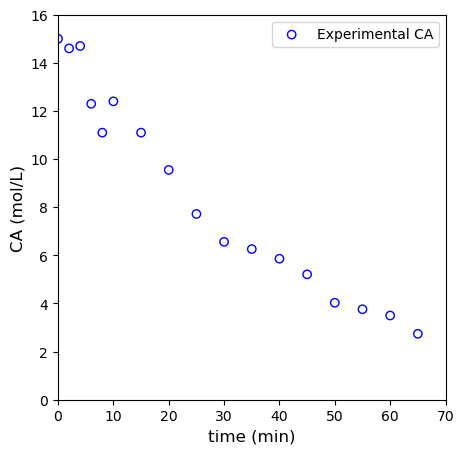

In [3]:
#####################################################################
# Add figure of CA vs. t data                                       #
#####################################################################

plt.figure(figsize = (5, 5))
plt.scatter(t1, CA1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

### Material Balance on the Batch Reactor

We know that this is a first order reaction in a constant volume batch reactor.  An appropriate material balance to model this system is:

$$\frac{dC_A}{dt} = -kC_A$$

And we know how to solve this analytically to get:

$$C_A = C_{A0}\exp(-kt)$$

So we have a nonlinear model.  We can overlay that model with a guess at the rate constant and see how well it agrees with our data.

For k = 0.01, residual sum of squares is SSE = 2.13E+02


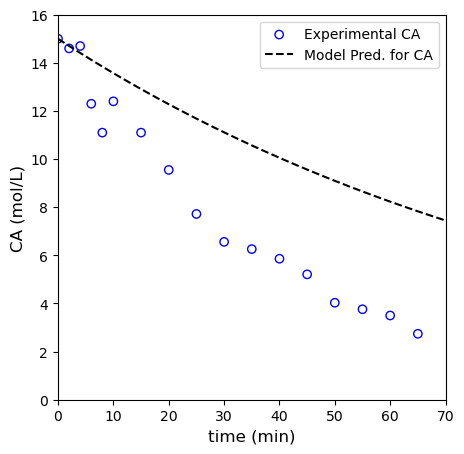

In [4]:
#######################################################################################
# Define model that describes first order reaction in a constant volume batch reactor #
#######################################################################################
CAfun = lambda k,t: CA01*np.exp(-k*t) 

#######################################################################################
# define test value of rate constant and time array to generate predictions           #
#######################################################################################

ktest = 0.01  #1/min
tmod  = np.linspace(0, 70, 100)

#######################################################################################
# Calculate SSE for ktest and experimental times                                      #
#######################################################################################
SSEtest = np.sum((CA1 - CAfun(ktest, t1))**2)
print(f'For k = {ktest:3.2f}, residual sum of squares is SSE = {SSEtest:3.2E}')

#######################################################################################
# Overlay predictions with observations using ktest                                   #
#######################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(t1, CA1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.plot(tmod, CAfun(ktest, tmod), label = 'Model Pred. for CA', color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

### Using an optimization routine

As usual, we can do much better by creating an objective function and minimizing it with an optimization routine.  Here, we'll create an objective function that calculates our sum of squares as a function of our variable parameter (the rate constant), and we'll use opt.minimize_scaler to find the "best" value of the rate constant, i.e., the one that minimizes the error between our model predictions and our measurments.

In [5]:
###############################################################################################
# Define objective function -- it will take unknown parameters as arguments, here obj1(k)     #
# It will calculate SSE for the value of k passed as an argument and return SSE               #
###############################################################################################

def obj1(par):
    k     = par 
    CAexp = CA1
    CAmod = CAfun(k, t1)  #mol/L    
    SSE = np.sum(((CAexp - CAmod))**2) 
    return SSE

###############################################################################################
# Minimize SSE to find optimal k                                                              #
###############################################################################################

ans1  = opt.minimize_scalar(obj1)#, method = 'Brent', bracket = [0.001, 1])

###############################################################################################
# Store and display answers at optimum                                                        #
###############################################################################################

k_opt = ans1.x
SSE   = ans1.fun
print(ans1, '\n')
print(f'The optimum rate constant is {k_opt:3.3f} 1/min with a SSE value of {SSE}')

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 5.21951743321773
       x: 0.024798795779924145
     nit: 19
    nfev: 22 

The optimum rate constant is 0.025 1/min with a SSE value of 5.21951743321773


Now that we know the optimum value of the rate constant, we can overlay the model with our measurments and see how well it does.  It is good to get in the habit of looking at the raw residual error as it gives you an idea of whether your measurements are randomly scattered about the best fit line, or if there is systematic deviation.  We'll calculate that quanity and plot it as a function of each measurement's concentration.

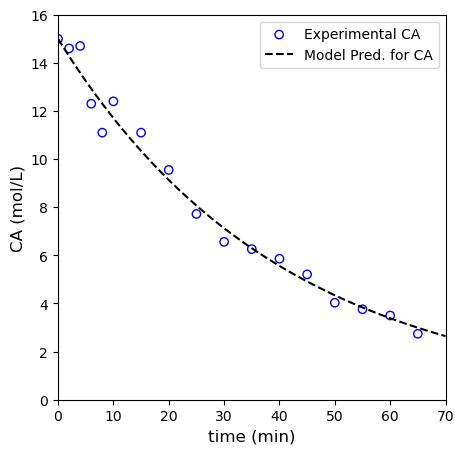

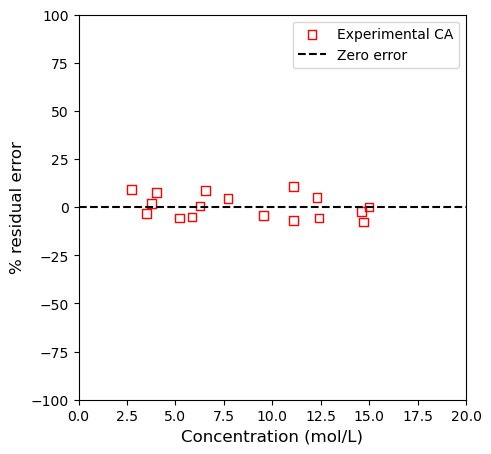

In [6]:
####################################################################################
# Calculate model result and residual error using optimum parameters               #
####################################################################################

CAmod = CAfun(k_opt, tmod)               #generate smooth curve showing model prediction as a continuous function of time
resid = (CAfun(k_opt, t1) - CA1)/CA1*100 #generate residual error at each experimental time

####################################################################################
# Overlay best fit model with measurements                                         #
####################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(t1, CA1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.plot(tmod, CAmod, label = 'Model Pred. for CA', color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

####################################################################################
# Generate plot of residual errors                                                 #
####################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CA1, resid, marker = 's', color = 'none', edgecolor = 'red', label = 'Experimental CA')
plt.hlines(0, 0, 20, color = 'black', linestyle = 'dashed', label = 'Zero error')
plt.xlim(0, 20)
plt.ylim(-100, 100)
plt.xlabel('Concentration (mol/L)', fontsize = 12)
plt.ylabel('% residual error', fontsize = 12)
plt.legend()
plt.show()

## Example Problem 02

The two following reactions occur in a constant volume batch reactor:

\begin{align}
    2A + B \longrightarrow C \\
    B  + 2C \longrightarrow D \\
\end{align}

Both reactions follow an elementary rate law; however, we do not know either of the rate constants ($k_1$ and $k_2$), so we attempt to estimate them from data collected in our constant volume batch reactor.  The data (time in minutes and concentrations of $A$, $B$, $C$, and $D$ in moles per liter) are included in the CSV files `N45_DATA2.csv`

The initial concentrations of species $A$ and $B$ are 25 and 20 moles per liter, respectively. The initial concentrations of $C$ and $D$ are both zero.

In [7]:
#################################################################################################
# Define the initial concentrations of A, B, C, and D -- these are fixed, global defs are fine  #
#################################################################################################

CA02 = 25.0  #mol/L
CB02 = 20.0  #mol/L
CC02 = 0.0   #mol/L
CD02 = 0.0   #mol/L

#################################################################################################
# Load t, CA, CB, CC, CD data for experiment 2 into a data frame                                #
#################################################################################################

DATA2df = pd.read_csv("N45_DATA2.csv")

#################################################################################################
# Convert dataframe into numpy array                                                            #
#################################################################################################

DATA2   = pd.DataFrame.to_numpy(DATA2df)

#################################################################################################
# Store t, CA, CB, CC, CD data in individual arrays; helps with human readability/comprehension #
#################################################################################################

t2      = DATA2[:, 0]
C2      = DATA2[:, 1:] #storing all concentrations in a single 2D array; used for plotting
CA2     = DATA2[:, 1]
CB2     = DATA2[:, 2]
CC2     = DATA2[:, 3]
CD2     = DATA2[:, 4]

#################################################################################################
# Display dataframe                                                                             #
#################################################################################################

DATA2df

,time (min),CA (mol/L),CB (mol/L),CC (mol/L),CD (mol/L)
0,0.0000,24.60,18.60,0.0000,0.000000e+00
1,0.0050,22.50,20.80,0.0501,1.230000e-07
2,0.0125,24.80,19.40,0.1320,2.030000e-06
3,0.0350,25.30,20.80,0.3610,3.950000e-05
4,0.0750,22.30,17.90,0.7000,3.750000e-04
5,0.1250,20.70,17.10,1.1900,1.480000e-03
6,0.2500,19.70,19.50,1.8900,9.900000e-03
7,0.5000,16.60,16.80,3.6500,5.640000e-02
8,1.0000,13.40,15.70,4.6000,2.190000e-01
9,2.0000,11.00,12.40,6.0600,7.890000e-01


### Visualize the data

Plot the data to get a feel for what we're working with.

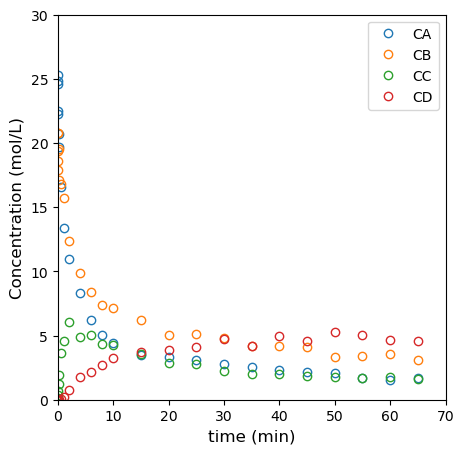

In [8]:
####################################################################################
# Generate scatterplot of t vs CA, CB, CC, CD                                      #
####################################################################################

plt.figure(figsize = (5, 5))
plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Concentration (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])
plt.show()

### Setting up the Least Squares Problem

When we move toward the least squares analysis, we should generally understand that we will compare experimental measurements with model predictions, and use the differences between them to calculate the residual sum of squares. The data we have available comprises experimentally measured values of $C_A$, $C_B$, $C_C$, and $C_D$ at various reaction times. We should try to use all of the data because we need to estimate parameters for both reactions, and the only way for us to do this is to account for changes in all species concentrations in our model predictions. Here, we run into a new issue in our optimization approach: we can't solve this reactor model analytically as we would with a normal "integral analysis" method. We will have to integrate it numerically. We have done this many times in solving batch or tubular reactor designs, the catch here is that we have to solve the model numerically in order to evaluate the obejctive function (residual sum of squares) that we are attempting to minimize. This is not difficult once you grasp how to wrap an optimizer around an ODE solver, but the code is tricky compared to what we have seen so far in the course. 

To start, let's just remember how we would solve the batch reactor problem in general if we are given known values $k_1$ and $k_2$. We do not know these values, of course, but there is nothing to stop us from assigning arbitrary numerical values to them to facilitate developing and visualizing the numerical solution for the batch reactor design problem.  Remember: for us to model the changes in species concentration in a batch reactor, we must write and solve the material balance for each species that is present in the reactor.

#### Material Balances on the Constant Volume Batch Reactor

A straightforward approach for determining species concentrations is to write the material balance for each species in a constant volume batch reactor:

\begin{align*}
    \frac{dC_A}{dt} &= R_A \\
    \frac{dC_B}{dt} &= R_B \\
    \frac{dC_C}{dt} &= R_C \\
    \frac{dC_D}{dt} &= R_D \\
\end{align*}

We can define production rates for each species as usual, $R_j = \sum_i \nu_{i,j}r_i$:

\begin{align*}
    R_A &= -2r_1 \\
    R_B &= -r_1 - r_2 \\
    R_C &= r_1 - 2r_2 \\
    R_D &= r_2 \\
\end{align*}

And both reactions are irreversible and follow elementary rate laws, so:

\begin{align*}
    r_1 = k_1{C_A}^2{C_B} \\
    r_2 = k_2{C_B}{C_C}^2 \\
\end{align*}

We do not ***know*** the values of $k_1$ and $k_2$ yet, but that's OK -- we are building a framework, so we will set arbitrary values for them just to get the ODE solution set up. We know that we are in a position (nonlinear least squares) that will require us to iteratively optimize values of $k_1$ and $k_2$, so we may as well set them to reasonable initial guesses and build the ODE solver before trying to run the optimizer on it.

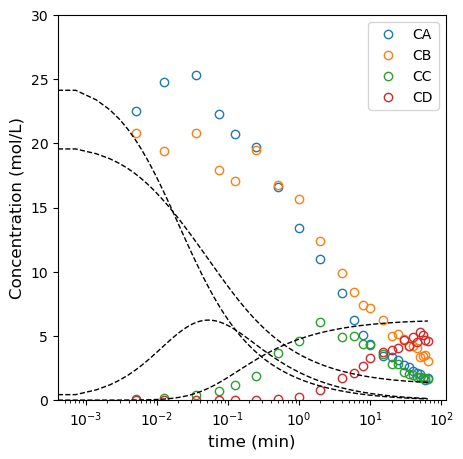

In [9]:
##############################################################################################
# Construct the ODE system; this is our set of material balances!                            #
# It has the usual form of f(t, [CA, CB, CC, CD])                                            #
# It returns [dCAdt, dCBdt, dCCdt, dCDdt]                                                    #
# We can integrate it for any time span we want using solve_ivp()                            #
##############################################################################################

def P2a(t, var):
    CA = var[0]
    CB = var[1]
    CC = var[2]
    CD = var[3]
    
    k1 = 0.05
    k2 = 0.05
    
    r1 = k1*CA**2*CB
    r2 = k2*CB*CC**2
    
    RA = -2*r1
    RB = -1*r1 - 1*r2
    RC =  1*r1 - 2*r2
    RD =  0*r1 + 1*r2
    
    D1 = RA
    D2 = RB
    D3 = RC
    D4 = RD
    return [D1, D2, D3, D4]

###############################################################################################
# Define parameters for solve_ivp(); initial guess and integration span                       #
###############################################################################################

C02    = [CA02, CB02, CC02, CD02] #mol/L
tspan2 = (0, max(t2))

###############################################################################################
# Integrate the ODE system using solve_ivp()                                                  #
###############################################################################################

ans2a  = solve_ivp(P2a, tspan2, C02, atol = 1e-8, rtol = 1e-8)

###############################################################################################
# Overlay the ODE solution with experimental data; use semilog x-axis to emphasize short t    #
###############################################################################################

plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(ans2a.t, ans2a.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.semilogx(ans2a.t, ans2a.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Concentration (mol/L)', fontsize = 12)
# plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])
plt.show()

### Create a more flexible ODE function that allows us to pass parameters

Our goal here is optimization -- we do not know the values of $k_1$ and $k_2$, and we will need to iteratively change their values until we find the results that minimize residual sum of squares. If this is our goal, we cannot hard code values for $k_1$ and $k_2$ as in the ODE function above. We should recognize that we will not be setting the rate constants ourselves, we will be allowing an optimization routine to iteratively change their values. The only way for us to do this is to make sure that we build the ODE function so that values of $k_1$ and $k_2$ are passed as parameters. We will build up to the optimization in a few steps.  The first one is to convert our ODE function to one that accepts parameters (rate constants here) as arguments; this will be essential for the optimization step.

```{tip}
This is actually something that we already know how to do! We can use `lambda` functions or (in Python) we can use the `args` keyword to pass extra parameters.
```

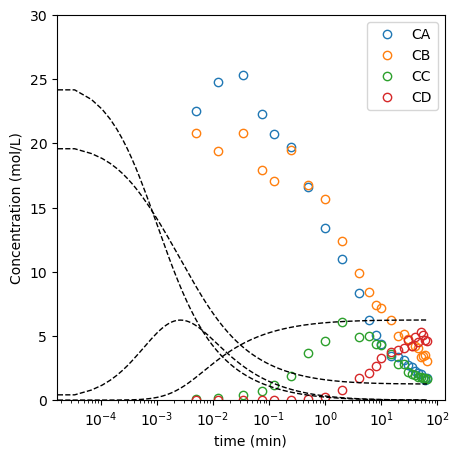

In [10]:
##############################################################################################
# Build a modified ODE function; this one accepts extra parameters as arguments              #
# Function can be flexible, but here it is built as f(t, [CA, CB, CC, CD], [k1, k2])         #
# Function still returns [dCAdt, dCBdt, dCCdt, dCDdt]                                        #
##############################################################################################

def P2b(t, var, par):
    CA = var[0]
    CB = var[1]
    CC = var[2]
    CD = var[3]
    
    k1 = par[0]
    k2 = par[1]
    
    r1 = k1*CA**2*CB
    r2 = k2*CB*CC**2
    
    RA = -2*r1
    RB = -1*r1 - 1*r2
    RC =  1*r1 - 2*r2
    RD =  0*r1 + 1*r2
    
    D1 = RA
    D2 = RB
    D3 = RC
    D4 = RD
    return [D1, D2, D3, D4]

#################################################################################################
# Set solve_ivp() initial conditions, integration span, and initial parameter values            #
#################################################################################################

C02    = [CA02, CB02, CC02, CD02] #mol/L
tspan2 = (0, max(t2))
par    = [1, 1]

#################################################################################################
# Integrate ODE system using solve_ivp(), note keyword argument here passes extra parameters    #
#################################################################################################

ans2b  = solve_ivp(P2b, tspan2, C02, args = (par, ), atol = 1e-8, rtol = 1e-8)

#################################################################################################
# Overlay the ODE solution for CA, CB, CC, and CD with experimental data                        #
# Note use of semilog plot -- x axis is log transformed to emphasize short time data            #
#################################################################################################

plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(ans2b.t, ans2b.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.semilogx(ans2b.t, ans2b.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('time (min)')
plt.ylabel('Concentration (mol/L)')
# plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])
plt.show()

### Use the ODE solver to evaluate your objective function

Now that we can solve the ODE system for arbitrary (and easily variable) values of $k_1$ and $k_2$, let's consider the next step for a least squares optimization. We need to find a way to calculate the residual sum of squares. There is no set way to do this, but for this particular experiment, one might note that we have data available for $C_A$, $C_B$, $C_C$, and $C_D$ as functions of time. Our best chance of estimating $k_1$ and $k_2$ is if we use all of the data in calculating our residual sum of squares.  One way to do that--the most straightforward way to do that--is to define the residual sum of squares as:

$$SSE = \sum_j \sum_k (C_{j,k} - \hat{C}_{j,k})^2$$

As a first step, let's just make sure we understand how to calculate the residual sum of squares from four different measured quantities using our ODE solution. We will do this first as a demo to make sure we know the steps. Once this is clear, we will build this concept into an objective function that we can optimize!

```{warning}
The code block below will throw an error -- this is intentional. It is there to demonstrate the size/shape incompatibility of experimental data set and model predictions made by the step-based ODE solver. This error arises because we cannot/should not attempt to control the steps taken by the ODE solver. By default, the solver will report the concentration results at the time steps it has taken, and there is essentially no chance that they are going to be the same as our experimental time stamps.
```

In [11]:
#################################################################################################
# Set solve_ivp() initial conditions, integration span, and initial parameter values            #
#################################################################################################

C02    = [CA02, CB02, CC02, CD02] #mol/L
tspan2 = (0, max(t2))
par0   = [0.05, 0.05]

####################################################################################################
# Integrate ODE system using solve_ivp() - this is our naive approach based on what we know so far #
####################################################################################################

ans2c   = solve_ivp(P2b, tspan2, C02, args = (par0, ), atol = 1e-8, rtol = 1e-8)
tmod    = ans2c.t
CAmod   = ans2c.y[0]
CBmod   = ans2c.y[1]
CCmod   = ans2c.y[2]
CDmod   = ans2c.y[3]
SSEA    = np.sum((CA2 - CAmod)**2)
SSEB    = np.sum((CB2 - CBmod)**2)
SSEC    = np.sum((CC2 - CCmod)**2)
SSED    = np.sum((CD2 - CDmod)**2)
SSE     = SSEA + SSEB + SSEC + SSED
print(SSE)

ValueError: operands could not be broadcast together with shapes (25,) (107,) 

```{important}
We should not try to control the integration steps taken by the ODE solver. These are sophisticated and well-tuned algorithms developed by people that understand Numerical Methods and Computer Science better than we do. We can however request that the ODE solver return solution values at specific steps using the `t_eval` keyword argument.
``` 

In [14]:
#################################################################################################
# Set solve_ivp() initial conditions, integration span, and initial parameter values            #
#################################################################################################

C02     = [CA02, CB02, CC02, CD02] #mol/L
tspan   = (0, max(t2))
par0    = [0.05, 0.05]

####################################################################################################
# Integrate ODE system using solve_ivp() - this uses the t_eval keyword to control output           #
####################################################################################################

ans2c   = solve_ivp(P2b, tspan, C02, args = (par0, ), atol = 1e-8, rtol = 1e-8, t_eval = t2) #here we specify time stamps where data should be returned
tmod    = ans2c.t
CAmod   = ans2c.y[0]
CBmod   = ans2c.y[1]
CCmod   = ans2c.y[2]
CDmod   = ans2c.y[3]
SSEA    = np.sum((CA2 - CAmod)**2)
SSEB    = np.sum((CB2 - CBmod)**2)
SSEC    = np.sum((CC2 - CCmod)**2)
SSED    = np.sum((CD2 - CDmod)**2)
SSE     = SSEA + SSEB + SSEC + SSED
print(SSE)

3071.8311047073753


Now that we have an understanding of how we could use a numerical solution to generate model predictions at various experimental times, we can embed this in an objective function. The main idea here is that we need to create a function (an objective function!) that (1) takes our parameter set (unknown values of $k_1$ and $k_2$) as an argument and (2) returns the residual sum of squares.  We have to bear in mind that calculating the residual sum of squares ***for this problem*** requires us to numerically integrate the ODE system using `solve_ivp()`, so this has to be embedded in the objective function. 

```{important}
With an objective function constructed as below, it is essential to recognize that we are running `solve_ivp()` using a new parameter set on each iteration taken by the optimization routine.  If you can understand this structure, the approach becomes relatively straightforward, and it can be generalized to many different types of problems.
```

In [15]:
##########################################################################################
# Define objective function; it has form f([k1, k2]) and it calculates and returns SSE   #
##########################################################################################

def obj2(par):
    ans2    = solve_ivp(P2b, tspan2, C02, args = (par, ), atol = 1e-8, rtol = 1e-8, t_eval = t2)
    CAMOD   = ans2.y[0]
    CBMOD   = ans2.y[1]
    CCMOD   = ans2.y[2]
    CDMOD   = ans2.y[3]
    SSEA    = np.sum((CA2 - CAMOD)**2)
    SSEB    = np.sum((CB2 - CBMOD)**2)
    SSEC    = np.sum((CC2 - CCMOD)**2)
    SSED    = np.sum((CD2 - CDMOD)**2) 
    SSE     = SSEA + SSEB + SSEC + SSED
    # print(f'For k1 = {par[0]:8.2E} and k2 = {par[1]:8.2E}, SSE = {SSE:8.2E}')
    return SSE

###########################################################################################
# Below is a naieve use of opt.minimize; this is what we would try first                  #
# You'll find that this one often has iterations that send k values negative              #
# This causes instability and prevents convergence                                        #
# This is a case where we should try to bound values of k1 and k2                         #
###########################################################################################

# par0  = [0.05, 0.05]
# ans2d = opt.minimize(obj2, par0)
    
###########################################################################################
# Below is a bounded optimization; we try this one after noticing the one above fails     #
# We only figure this out after we understand why the unconstrained optimization fails    #
###########################################################################################

bnds  = ((0, None), (0, None))
ans2d = opt.minimize(obj2, par0, method = 'L-BFGS-B', bounds = bnds)

###########################################################################################
# Display the answers, bind to variable names as appropriate                              #
###########################################################################################

print(ans2d, '\n')
k1_opt, k2_opt = ans2d.x
par_opt = ans2d.x
SSE   = ans2d.fun
print(f'The optimum rates constant are k1 = {k1_opt:3.3E} and k2 = {k2_opt:3.3E} giving an SSE value of {SSE:3.3f}')

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 33.18150076035556
        x: [ 9.021e-04  1.281e-03]
      nit: 9
      jac: [-1.153e-02  4.311e-03]
     nfev: 60
     njev: 20
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

The optimum rates constant are k1 = 9.021E-04 and k2 = 1.281E-03 giving an SSE value of 33.182


We can see from the output from `opt.minimize()` that the solver converged and we were able to find optimal values of $k_1 = 9.02E-4$ and $k_2 = 1.28E-3$. Now we will pass these optimal results to the ODE solver and re-integrate the coupled system once more to obtain concentration profiles for the optimal parameter set. We will then overlay these with experimental measurements to assess goodness of fit.

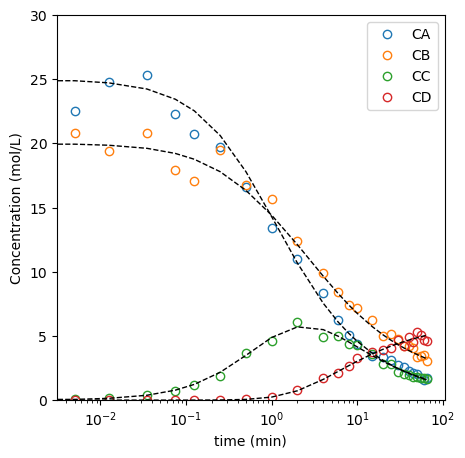

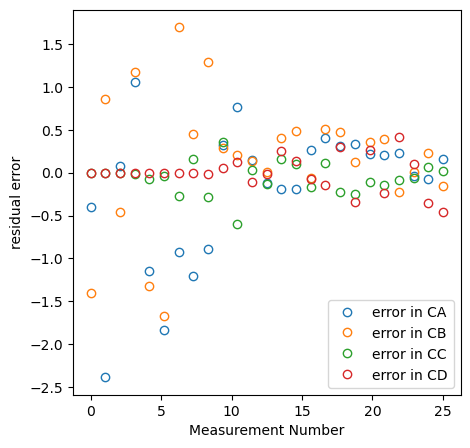

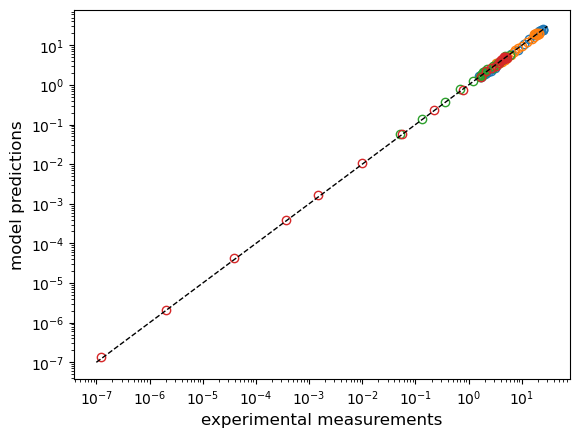

In [16]:
#########################################################################################################
# Solve the ODE system one more time with the optimal values of k1 and k2                               #
#########################################################################################################

ans2e  = solve_ivp(P2b, tspan, C02, args = (par_opt, ), atol = 1e-8, rtol = 1e-8, t_eval = t2)

#########################################################################################################
# Block below is calculating residual errors; noting dimensions in experiment and model                 #
# Need to make sure arrays are size/shape compatbile for math, e.g., transpose model results            #
#########################################################################################################

# print(C2)
# print(C2.shape)
# print(ans2e.y)
# print(ans2e.y.shape)
# print(ans2e.y.T)
# print(ans2e.y.T.shape)
resid  = (C2 - ans2e.y.T) #calculating all residuals as a 2D array
nexp   = len(t2)
expn   = np.linspace(0, nexp, nexp)

#########################################################################################################
# Overlay experimental results with model prediction using optimum parameter set                        #
#########################################################################################################

plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(ans2e.t, ans2e.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.semilogx(ans2e.t, ans2e.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('time (min)')
plt.ylabel('Concentration (mol/L)')
# plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])

#########################################################################################################
# Generate plot of residual errors                                                                      #
#########################################################################################################

plt.figure(figsize = (5, 5))
plt.plot(expn, resid, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.xlabel('Measurement Number')
plt.ylabel('residual error')
plt.legend(['error in CA', 'error in CB', 'error in CC', 'error in CD'], loc = 'lower right')
plt.show()

#########################################################################################################
# Generate parity plot of log(CA) data to test level of model vs. experiment agreement                  #
#########################################################################################################

parity = [1e-7, 30]
# plt.plot(C2, ans2e.y.T, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(parity, parity, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.loglog(C2, ans2e.y.T, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.loglog(parity, parity, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('experimental measurements', fontsize = 12)
plt.ylabel('model predictions', fontsize = 12)
plt.show()